# Read and load results

In [115]:
from functions import *
from Classes import *

# Define the use technologies and regions(s)
region = 'ESP'  
setup = {
    f'{region}': {
        'OCGT': True,
        'CCGT': False,
        'battery storage': True,
        'onwind': True,
        'offwind': False,
        'solar': True,
        'electrolysis': True,
        'fuel cell': True,
        'Hydrogen storage': True,
        'Reservoir hydro storage': True,
        'Load shedding': False
    }
}

# Default weather, hydro and demand years
w_year_exp = 2011
h_year_exp = 2007
d_year_exp = 2018

# Dispatch and rolling horizon settings
w_year_dispatch = 2017
h_year_dispatch = 2007
d_year_dispatch = 2019

weather_years = All_data['solar'].index.year.unique()


In [116]:
# folder_rh = f"N_RH_d_{d_year_dispatch}_hMC_high2"
# folder_pf = f"N_PF_d_{d_year_dispatch}_hMC_high2"

test_name = "_0BS_hSPC"  # Name to append to files for identification

folder_rh = f"N_RH_d_{d_year_dispatch}_h_{h_year_dispatch}{test_name}"
folder_pf = f"N_PF_d_{d_year_dispatch}_h_{h_year_dispatch}{test_name}"

networks_rh = load_networks(folder_name = folder_rh, weather_years = weather_years)
networks_pf = load_networks(folder_name = folder_pf, weather_years = weather_years)

INFO:pypsa.io:Imported network N_RH_w-1979_d-2019_h-2007_ESP_0BS_hSPC.nc has buses, carriers, generators, links, loads, storage_units, stores
INFO:pypsa.io:Imported network N_RH_w-1980_d-2019_h-2007_ESP_0BS_hSPC.nc has buses, carriers, generators, links, loads, storage_units, stores


Loaded N_1979 from N_RH_w-1979_d-2019_h-2007_ESP_0BS_hSPC.nc
Loaded N_1980 from N_RH_w-1980_d-2019_h-2007_ESP_0BS_hSPC.nc


INFO:pypsa.io:Imported network N_RH_w-1981_d-2019_h-2007_ESP_0BS_hSPC.nc has buses, carriers, generators, links, loads, storage_units, stores
INFO:pypsa.io:Imported network N_RH_w-1982_d-2019_h-2007_ESP_0BS_hSPC.nc has buses, carriers, generators, links, loads, storage_units, stores


Loaded N_1981 from N_RH_w-1981_d-2019_h-2007_ESP_0BS_hSPC.nc
Loaded N_1982 from N_RH_w-1982_d-2019_h-2007_ESP_0BS_hSPC.nc


INFO:pypsa.io:Imported network N_RH_w-1983_d-2019_h-2007_ESP_0BS_hSPC.nc has buses, carriers, generators, links, loads, storage_units, stores
INFO:pypsa.io:Imported network N_RH_w-1984_d-2019_h-2007_ESP_0BS_hSPC.nc has buses, carriers, generators, links, loads, storage_units, stores


Loaded N_1983 from N_RH_w-1983_d-2019_h-2007_ESP_0BS_hSPC.nc
Loaded N_1984 from N_RH_w-1984_d-2019_h-2007_ESP_0BS_hSPC.nc


INFO:pypsa.io:Imported network N_RH_w-1985_d-2019_h-2007_ESP_0BS_hSPC.nc has buses, carriers, generators, links, loads, storage_units, stores
INFO:pypsa.io:Imported network N_RH_w-1986_d-2019_h-2007_ESP_0BS_hSPC.nc has buses, carriers, generators, links, loads, storage_units, stores


Loaded N_1985 from N_RH_w-1985_d-2019_h-2007_ESP_0BS_hSPC.nc
Loaded N_1986 from N_RH_w-1986_d-2019_h-2007_ESP_0BS_hSPC.nc


INFO:pypsa.io:Imported network N_RH_w-1987_d-2019_h-2007_ESP_0BS_hSPC.nc has buses, carriers, generators, links, loads, storage_units, stores
INFO:pypsa.io:Imported network N_RH_w-1988_d-2019_h-2007_ESP_0BS_hSPC.nc has buses, carriers, generators, links, loads, storage_units, stores


Loaded N_1987 from N_RH_w-1987_d-2019_h-2007_ESP_0BS_hSPC.nc
Loaded N_1988 from N_RH_w-1988_d-2019_h-2007_ESP_0BS_hSPC.nc


INFO:pypsa.io:Imported network N_RH_w-1989_d-2019_h-2007_ESP_0BS_hSPC.nc has buses, carriers, generators, links, loads, storage_units, stores
INFO:pypsa.io:Imported network N_RH_w-1990_d-2019_h-2007_ESP_0BS_hSPC.nc has buses, carriers, generators, links, loads, storage_units, stores


Loaded N_1989 from N_RH_w-1989_d-2019_h-2007_ESP_0BS_hSPC.nc
Loaded N_1990 from N_RH_w-1990_d-2019_h-2007_ESP_0BS_hSPC.nc


INFO:pypsa.io:Imported network N_RH_w-1991_d-2019_h-2007_ESP_0BS_hSPC.nc has buses, carriers, generators, links, loads, storage_units, stores
INFO:pypsa.io:Imported network N_RH_w-1992_d-2019_h-2007_ESP_0BS_hSPC.nc has buses, carriers, generators, links, loads, storage_units, stores


Loaded N_1991 from N_RH_w-1991_d-2019_h-2007_ESP_0BS_hSPC.nc
Loaded N_1992 from N_RH_w-1992_d-2019_h-2007_ESP_0BS_hSPC.nc


INFO:pypsa.io:Imported network N_RH_w-1993_d-2019_h-2007_ESP_0BS_hSPC.nc has buses, carriers, generators, links, loads, storage_units, stores


Loaded N_1993 from N_RH_w-1993_d-2019_h-2007_ESP_0BS_hSPC.nc


INFO:pypsa.io:Imported network N_RH_w-1994_d-2019_h-2007_ESP_0BS_hSPC.nc has buses, carriers, generators, links, loads, storage_units, stores


Loaded N_1994 from N_RH_w-1994_d-2019_h-2007_ESP_0BS_hSPC.nc


INFO:pypsa.io:Imported network N_RH_w-1995_d-2019_h-2007_ESP_0BS_hSPC.nc has buses, carriers, generators, links, loads, storage_units, stores


Loaded N_1995 from N_RH_w-1995_d-2019_h-2007_ESP_0BS_hSPC.nc


INFO:pypsa.io:Imported network N_RH_w-1996_d-2019_h-2007_ESP_0BS_hSPC.nc has buses, carriers, generators, links, loads, storage_units, stores


Loaded N_1996 from N_RH_w-1996_d-2019_h-2007_ESP_0BS_hSPC.nc


INFO:pypsa.io:Imported network N_RH_w-1997_d-2019_h-2007_ESP_0BS_hSPC.nc has buses, carriers, generators, links, loads, storage_units, stores


Loaded N_1997 from N_RH_w-1997_d-2019_h-2007_ESP_0BS_hSPC.nc


INFO:pypsa.io:Imported network N_RH_w-1998_d-2019_h-2007_ESP_0BS_hSPC.nc has buses, carriers, generators, links, loads, storage_units, stores


Loaded N_1998 from N_RH_w-1998_d-2019_h-2007_ESP_0BS_hSPC.nc


INFO:pypsa.io:Imported network N_RH_w-1999_d-2019_h-2007_ESP_0BS_hSPC.nc has buses, carriers, generators, links, loads, storage_units, stores
INFO:pypsa.io:Imported network N_RH_w-2000_d-2019_h-2007_ESP_0BS_hSPC.nc has buses, carriers, generators, links, loads, storage_units, stores


Loaded N_1999 from N_RH_w-1999_d-2019_h-2007_ESP_0BS_hSPC.nc
Loaded N_2000 from N_RH_w-2000_d-2019_h-2007_ESP_0BS_hSPC.nc


INFO:pypsa.io:Imported network N_RH_w-2001_d-2019_h-2007_ESP_0BS_hSPC.nc has buses, carriers, generators, links, loads, storage_units, stores


Loaded N_2001 from N_RH_w-2001_d-2019_h-2007_ESP_0BS_hSPC.nc


INFO:pypsa.io:Imported network N_RH_w-2002_d-2019_h-2007_ESP_0BS_hSPC.nc has buses, carriers, generators, links, loads, storage_units, stores


Loaded N_2002 from N_RH_w-2002_d-2019_h-2007_ESP_0BS_hSPC.nc


INFO:pypsa.io:Imported network N_RH_w-2003_d-2019_h-2007_ESP_0BS_hSPC.nc has buses, carriers, generators, links, loads, storage_units, stores
INFO:pypsa.io:Imported network N_RH_w-2004_d-2019_h-2007_ESP_0BS_hSPC.nc has buses, carriers, generators, links, loads, storage_units, stores


Loaded N_2003 from N_RH_w-2003_d-2019_h-2007_ESP_0BS_hSPC.nc
Loaded N_2004 from N_RH_w-2004_d-2019_h-2007_ESP_0BS_hSPC.nc


INFO:pypsa.io:Imported network N_RH_w-2005_d-2019_h-2007_ESP_0BS_hSPC.nc has buses, carriers, generators, links, loads, storage_units, stores
INFO:pypsa.io:Imported network N_RH_w-2006_d-2019_h-2007_ESP_0BS_hSPC.nc has buses, carriers, generators, links, loads, storage_units, stores


Loaded N_2005 from N_RH_w-2005_d-2019_h-2007_ESP_0BS_hSPC.nc


INFO:pypsa.io:Imported network N_RH_w-2007_d-2019_h-2007_ESP_0BS_hSPC.nc has buses, carriers, generators, links, loads, storage_units, stores


Loaded N_2006 from N_RH_w-2006_d-2019_h-2007_ESP_0BS_hSPC.nc
Loaded N_2007 from N_RH_w-2007_d-2019_h-2007_ESP_0BS_hSPC.nc


INFO:pypsa.io:Imported network N_RH_w-2008_d-2019_h-2007_ESP_0BS_hSPC.nc has buses, carriers, generators, links, loads, storage_units, stores
INFO:pypsa.io:Imported network N_RH_w-2009_d-2019_h-2007_ESP_0BS_hSPC.nc has buses, carriers, generators, links, loads, storage_units, stores


Loaded N_2008 from N_RH_w-2008_d-2019_h-2007_ESP_0BS_hSPC.nc


INFO:pypsa.io:Imported network N_RH_w-2010_d-2019_h-2007_ESP_0BS_hSPC.nc has buses, carriers, generators, links, loads, storage_units, stores


Loaded N_2009 from N_RH_w-2009_d-2019_h-2007_ESP_0BS_hSPC.nc
Loaded N_2010 from N_RH_w-2010_d-2019_h-2007_ESP_0BS_hSPC.nc


INFO:pypsa.io:Imported network N_RH_w-2011_d-2019_h-2007_ESP_0BS_hSPC.nc has buses, carriers, generators, links, loads, storage_units, stores
INFO:pypsa.io:Imported network N_RH_w-2012_d-2019_h-2007_ESP_0BS_hSPC.nc has buses, carriers, generators, links, loads, storage_units, stores


Loaded N_2011 from N_RH_w-2011_d-2019_h-2007_ESP_0BS_hSPC.nc
Loaded N_2012 from N_RH_w-2012_d-2019_h-2007_ESP_0BS_hSPC.nc


INFO:pypsa.io:Imported network N_RH_w-2013_d-2019_h-2007_ESP_0BS_hSPC.nc has buses, carriers, generators, links, loads, storage_units, stores
INFO:pypsa.io:Imported network N_RH_w-2014_d-2019_h-2007_ESP_0BS_hSPC.nc has buses, carriers, generators, links, loads, storage_units, stores


Loaded N_2013 from N_RH_w-2013_d-2019_h-2007_ESP_0BS_hSPC.nc
Loaded N_2014 from N_RH_w-2014_d-2019_h-2007_ESP_0BS_hSPC.nc


INFO:pypsa.io:Imported network N_RH_w-2015_d-2019_h-2007_ESP_0BS_hSPC.nc has buses, carriers, generators, links, loads, storage_units, stores
INFO:pypsa.io:Imported network N_RH_w-2016_d-2019_h-2007_ESP_0BS_hSPC.nc has buses, carriers, generators, links, loads, storage_units, stores


Loaded N_2015 from N_RH_w-2015_d-2019_h-2007_ESP_0BS_hSPC.nc
Loaded N_2016 from N_RH_w-2016_d-2019_h-2007_ESP_0BS_hSPC.nc


INFO:pypsa.io:Imported network N_RH_w-2017_d-2019_h-2007_ESP_0BS_hSPC.nc has buses, carriers, generators, links, loads, storage_units, stores


Loaded N_2017 from N_RH_w-2017_d-2019_h-2007_ESP_0BS_hSPC.nc


INFO:pypsa.io:Imported network N_PF_w-1979_d-2019_h-2007_ESP_0BS_hSPC.nc has buses, carriers, generators, links, loads, storage_units, stores
INFO:pypsa.io:Imported network N_PF_w-1980_d-2019_h-2007_ESP_0BS_hSPC.nc has buses, carriers, generators, links, loads, storage_units, stores


Loaded N_1979 from N_PF_w-1979_d-2019_h-2007_ESP_0BS_hSPC.nc
Loaded N_1980 from N_PF_w-1980_d-2019_h-2007_ESP_0BS_hSPC.nc


INFO:pypsa.io:Imported network N_PF_w-1981_d-2019_h-2007_ESP_0BS_hSPC.nc has buses, carriers, generators, links, loads, storage_units, stores
INFO:pypsa.io:Imported network N_PF_w-1982_d-2019_h-2007_ESP_0BS_hSPC.nc has buses, carriers, generators, links, loads, storage_units, stores


Loaded N_1981 from N_PF_w-1981_d-2019_h-2007_ESP_0BS_hSPC.nc
Loaded N_1982 from N_PF_w-1982_d-2019_h-2007_ESP_0BS_hSPC.nc


INFO:pypsa.io:Imported network N_PF_w-1983_d-2019_h-2007_ESP_0BS_hSPC.nc has buses, carriers, generators, links, loads, storage_units, stores
INFO:pypsa.io:Imported network N_PF_w-1984_d-2019_h-2007_ESP_0BS_hSPC.nc has buses, carriers, generators, links, loads, storage_units, stores


Loaded N_1983 from N_PF_w-1983_d-2019_h-2007_ESP_0BS_hSPC.nc
Loaded N_1984 from N_PF_w-1984_d-2019_h-2007_ESP_0BS_hSPC.nc


INFO:pypsa.io:Imported network N_PF_w-1985_d-2019_h-2007_ESP_0BS_hSPC.nc has buses, carriers, generators, links, loads, storage_units, stores


Loaded N_1985 from N_PF_w-1985_d-2019_h-2007_ESP_0BS_hSPC.nc


INFO:pypsa.io:Imported network N_PF_w-1986_d-2019_h-2007_ESP_0BS_hSPC.nc has buses, carriers, generators, links, loads, storage_units, stores


Loaded N_1986 from N_PF_w-1986_d-2019_h-2007_ESP_0BS_hSPC.nc


INFO:pypsa.io:Imported network N_PF_w-1987_d-2019_h-2007_ESP_0BS_hSPC.nc has buses, carriers, generators, links, loads, storage_units, stores


Loaded N_1987 from N_PF_w-1987_d-2019_h-2007_ESP_0BS_hSPC.nc


INFO:pypsa.io:Imported network N_PF_w-1988_d-2019_h-2007_ESP_0BS_hSPC.nc has buses, carriers, generators, links, loads, storage_units, stores
INFO:pypsa.io:Imported network N_PF_w-1989_d-2019_h-2007_ESP_0BS_hSPC.nc has buses, carriers, generators, links, loads, storage_units, stores


Loaded N_1988 from N_PF_w-1988_d-2019_h-2007_ESP_0BS_hSPC.nc
Loaded N_1989 from N_PF_w-1989_d-2019_h-2007_ESP_0BS_hSPC.nc


INFO:pypsa.io:Imported network N_PF_w-1990_d-2019_h-2007_ESP_0BS_hSPC.nc has buses, carriers, generators, links, loads, storage_units, stores
INFO:pypsa.io:Imported network N_PF_w-1991_d-2019_h-2007_ESP_0BS_hSPC.nc has buses, carriers, generators, links, loads, storage_units, stores


Loaded N_1990 from N_PF_w-1990_d-2019_h-2007_ESP_0BS_hSPC.nc
Loaded N_1991 from N_PF_w-1991_d-2019_h-2007_ESP_0BS_hSPC.nc


INFO:pypsa.io:Imported network N_PF_w-1992_d-2019_h-2007_ESP_0BS_hSPC.nc has buses, carriers, generators, links, loads, storage_units, stores
INFO:pypsa.io:Imported network N_PF_w-1993_d-2019_h-2007_ESP_0BS_hSPC.nc has buses, carriers, generators, links, loads, storage_units, stores


Loaded N_1992 from N_PF_w-1992_d-2019_h-2007_ESP_0BS_hSPC.nc


INFO:pypsa.io:Imported network N_PF_w-1994_d-2019_h-2007_ESP_0BS_hSPC.nc has buses, carriers, generators, links, loads, storage_units, stores


Loaded N_1993 from N_PF_w-1993_d-2019_h-2007_ESP_0BS_hSPC.nc


INFO:pypsa.io:Imported network N_PF_w-1995_d-2019_h-2007_ESP_0BS_hSPC.nc has buses, carriers, generators, links, loads, storage_units, stores


Loaded N_1994 from N_PF_w-1994_d-2019_h-2007_ESP_0BS_hSPC.nc


INFO:pypsa.io:Imported network N_PF_w-1996_d-2019_h-2007_ESP_0BS_hSPC.nc has buses, carriers, generators, links, loads, storage_units, stores


Loaded N_1995 from N_PF_w-1995_d-2019_h-2007_ESP_0BS_hSPC.nc
Loaded N_1996 from N_PF_w-1996_d-2019_h-2007_ESP_0BS_hSPC.nc


INFO:pypsa.io:Imported network N_PF_w-1997_d-2019_h-2007_ESP_0BS_hSPC.nc has buses, carriers, generators, links, loads, storage_units, stores
INFO:pypsa.io:Imported network N_PF_w-1998_d-2019_h-2007_ESP_0BS_hSPC.nc has buses, carriers, generators, links, loads, storage_units, stores


Loaded N_1997 from N_PF_w-1997_d-2019_h-2007_ESP_0BS_hSPC.nc
Loaded N_1998 from N_PF_w-1998_d-2019_h-2007_ESP_0BS_hSPC.nc


INFO:pypsa.io:Imported network N_PF_w-1999_d-2019_h-2007_ESP_0BS_hSPC.nc has buses, carriers, generators, links, loads, storage_units, stores
INFO:pypsa.io:Imported network N_PF_w-2000_d-2019_h-2007_ESP_0BS_hSPC.nc has buses, carriers, generators, links, loads, storage_units, stores


Loaded N_1999 from N_PF_w-1999_d-2019_h-2007_ESP_0BS_hSPC.nc
Loaded N_2000 from N_PF_w-2000_d-2019_h-2007_ESP_0BS_hSPC.nc


INFO:pypsa.io:Imported network N_PF_w-2001_d-2019_h-2007_ESP_0BS_hSPC.nc has buses, carriers, generators, links, loads, storage_units, stores


Loaded N_2001 from N_PF_w-2001_d-2019_h-2007_ESP_0BS_hSPC.nc


INFO:pypsa.io:Imported network N_PF_w-2002_d-2019_h-2007_ESP_0BS_hSPC.nc has buses, carriers, generators, links, loads, storage_units, stores


Loaded N_2002 from N_PF_w-2002_d-2019_h-2007_ESP_0BS_hSPC.nc


INFO:pypsa.io:Imported network N_PF_w-2003_d-2019_h-2007_ESP_0BS_hSPC.nc has buses, carriers, generators, links, loads, storage_units, stores


Loaded N_2003 from N_PF_w-2003_d-2019_h-2007_ESP_0BS_hSPC.nc


INFO:pypsa.io:Imported network N_PF_w-2004_d-2019_h-2007_ESP_0BS_hSPC.nc has buses, carriers, generators, links, loads, storage_units, stores


Loaded N_2004 from N_PF_w-2004_d-2019_h-2007_ESP_0BS_hSPC.nc


INFO:pypsa.io:Imported network N_PF_w-2005_d-2019_h-2007_ESP_0BS_hSPC.nc has buses, carriers, generators, links, loads, storage_units, stores


Loaded N_2005 from N_PF_w-2005_d-2019_h-2007_ESP_0BS_hSPC.nc


INFO:pypsa.io:Imported network N_PF_w-2006_d-2019_h-2007_ESP_0BS_hSPC.nc has buses, carriers, generators, links, loads, storage_units, stores


Loaded N_2006 from N_PF_w-2006_d-2019_h-2007_ESP_0BS_hSPC.nc


INFO:pypsa.io:Imported network N_PF_w-2007_d-2019_h-2007_ESP_0BS_hSPC.nc has buses, carriers, generators, links, loads, storage_units, stores
INFO:pypsa.io:Imported network N_PF_w-2008_d-2019_h-2007_ESP_0BS_hSPC.nc has buses, carriers, generators, links, loads, storage_units, stores


Loaded N_2007 from N_PF_w-2007_d-2019_h-2007_ESP_0BS_hSPC.nc


INFO:pypsa.io:Imported network N_PF_w-2009_d-2019_h-2007_ESP_0BS_hSPC.nc has buses, carriers, generators, links, loads, storage_units, stores


Loaded N_2008 from N_PF_w-2008_d-2019_h-2007_ESP_0BS_hSPC.nc
Loaded N_2009 from N_PF_w-2009_d-2019_h-2007_ESP_0BS_hSPC.nc


INFO:pypsa.io:Imported network N_PF_w-2010_d-2019_h-2007_ESP_0BS_hSPC.nc has buses, carriers, generators, links, loads, storage_units, stores
INFO:pypsa.io:Imported network N_PF_w-2011_d-2019_h-2007_ESP_0BS_hSPC.nc has buses, carriers, generators, links, loads, storage_units, stores


Loaded N_2010 from N_PF_w-2010_d-2019_h-2007_ESP_0BS_hSPC.nc


INFO:pypsa.io:Imported network N_PF_w-2012_d-2019_h-2007_ESP_0BS_hSPC.nc has buses, carriers, generators, links, loads, storage_units, stores


Loaded N_2011 from N_PF_w-2011_d-2019_h-2007_ESP_0BS_hSPC.nc
Loaded N_2012 from N_PF_w-2012_d-2019_h-2007_ESP_0BS_hSPC.nc


INFO:pypsa.io:Imported network N_PF_w-2013_d-2019_h-2007_ESP_0BS_hSPC.nc has buses, carriers, generators, links, loads, storage_units, stores
INFO:pypsa.io:Imported network N_PF_w-2014_d-2019_h-2007_ESP_0BS_hSPC.nc has buses, carriers, generators, links, loads, storage_units, stores


Loaded N_2013 from N_PF_w-2013_d-2019_h-2007_ESP_0BS_hSPC.nc
Loaded N_2014 from N_PF_w-2014_d-2019_h-2007_ESP_0BS_hSPC.nc


INFO:pypsa.io:Imported network N_PF_w-2015_d-2019_h-2007_ESP_0BS_hSPC.nc has buses, carriers, generators, links, loads, storage_units, stores
INFO:pypsa.io:Imported network N_PF_w-2016_d-2019_h-2007_ESP_0BS_hSPC.nc has buses, carriers, generators, links, loads, storage_units, stores


Loaded N_2015 from N_PF_w-2015_d-2019_h-2007_ESP_0BS_hSPC.nc
Loaded N_2016 from N_PF_w-2016_d-2019_h-2007_ESP_0BS_hSPC.nc


INFO:pypsa.io:Imported network N_PF_w-2017_d-2019_h-2007_ESP_0BS_hSPC.nc has buses, carriers, generators, links, loads, storage_units, stores


Loaded N_2017 from N_PF_w-2017_d-2019_h-2007_ESP_0BS_hSPC.nc


In [118]:
print_Results(networks_rh[2005])


Objective value (MEUR): 1

Installed generator capacities (MW):
Generator
OCGT             22180.0
onwind           63049.0
solar            24064.0
load shedding        0.0

Installed store energy capacities (MWh):
Store
Hydrogen storage    0.0

Installed hydro power capacity (MW):
StorageUnit
Reservoir hydro storage    12700.0

Installed link power capacities (MW):
Link
electrolysis    0.0
fuel cell       0.0


In [126]:
sum(getattr(networks_rh[1989], "_rolling_objectives", []))
networks_rh[2005]._rolling_runs

AttributeError: 'Network' object has no attribute '_rolling_runs'

# Build df and tables to store results

In [127]:
" MED lille l i load shedding "

# Results storage
results = []

for year in weather_years[:28]:  # Limiting to first 28 years for quicker testing
    pf_net = networks_pf[year]
    rh_net = networks_rh[year]

    # System costs
    pf_cost = (pf_net.buses_t['marginal_price']['electricity bus'] * 
               pf_net.loads_t['p_set']['load']).sum() / 1e6
    rh_cost = (rh_net.buses_t['marginal_price']['electricity bus'] * 
               rh_net.loads_t['p_set']['load']).sum() / 1e6
    diff = rh_cost - pf_cost

    # Load shedding cost for RH model
    if "load shedding" in rh_net.generators.index:
        ls_dispatch_rh = rh_net.generators_t.p["load shedding"]
        ls_cost_rh = rh_net.generators.at["load shedding", "marginal_cost"]
        ls_total_cost_rh = (ls_dispatch_rh * ls_cost_rh).sum() / 1e6
    else:
        ls_total_cost_rh = 0.0

    # Load shedding cost for PF model
    if "load shedding" in pf_net.generators.index:
        ls_dispatch_pf = pf_net.generators_t.p["load shedding"]
        ls_cost_pf = pf_net.generators.at["load shedding", "marginal_cost"]
        ls_total_cost_pf = (ls_dispatch_pf * ls_cost_pf).sum() / 1e6
    else:
        ls_total_cost_pf = 0.0

    results.append({
        'year': year,
        #'Objective value_MEUR': round(pf_net.objective, 1),
        #'RH_objective_value_MEUR': round(rh_net., 1),
        'PF_cost_MEUR': round(pf_cost, 1),
        'RH_cost_MEUR': round(rh_cost, 1),
        'Difference_MEUR': round(diff, 1),
        'PF_load_shedding_cost_MEUR': round(ls_total_cost_pf, 1),
        'RH_load_shedding_cost_MEUR': round(ls_total_cost_rh, 1)
    })

results_df = pd.DataFrame(results)
results_df


,year,PF_cost_MEUR,RH_cost_MEUR,Difference_MEUR,PF_load_shedding_cost_MEUR,RH_load_shedding_cost_MEUR
0,1979,11600.1,15263.8,3663.7,0.0,230.9
1,1980,12271.5,13679.2,1407.6,0.0,142.4
2,1981,11817.9,15853.8,4035.9,0.0,167.7
3,1982,12319.5,15488.1,3168.6,0.0,305.6
4,1983,12582.0,17892.5,5310.6,0.0,159.0
5,1984,11885.4,12815.5,930.1,0.0,18.1
6,1985,12273.0,12983.9,711.0,0.0,57.5
7,1986,12164.0,15128.1,2964.1,0.0,62.8
8,1987,12320.6,13177.0,856.4,0.0,72.7
9,1988,12207.1,15217.3,3010.2,0.7,183.7


In [ ]:
" MED STORT L i Load shedding "

# Results storage
results = []

for year in weather_years[:28]:  # Limiting to first 28 years for quicker testing
    pf_net = networks_pf[year]
    rh_net = networks_rh[year]

    # System costs
    pf_cost = (pf_net.buses_t['marginal_price']['electricity bus'] * 
               pf_net.loads_t['p_set']['load']).sum() / 1e6
    rh_cost = (rh_net.buses_t['marginal_price']['electricity bus'] * 
               rh_net.loads_t['p_set']['load']).sum() / 1e6
    diff = rh_cost - pf_cost

    # Load shedding cost for RH model
    if "Load shedding" in rh_net.generators.index:
        ls_dispatch_rh = rh_net.generators_t.p["Load shedding"]
        ls_cost_rh = rh_net.generators.at["Load shedding", "marginal_cost"]
        ls_total_cost_rh = (ls_dispatch_rh * ls_cost_rh).sum() / 1e6
    else:
        ls_total_cost_rh = 0.0

    # Load shedding cost for PF model
    if "Load shedding" in pf_net.generators.index:
        ls_dispatch_pf = pf_net.generators_t.p["Load shedding"]
        ls_cost_pf = pf_net.generators.at["Load shedding", "marginal_cost"]
        ls_total_cost_pf = (ls_dispatch_pf * ls_cost_pf).sum() / 1e6
    else:
        ls_total_cost_pf = 0.0

    results.append({
        'year': year,
        'PF_cost_MEUR': round(pf_cost, 1),
        'RH_cost_MEUR': round(rh_cost, 1),
        'Difference_MEUR': round(diff, 1),
        'PF_load_shedding_cost_MEUR': round(ls_total_cost_pf, 1),
        'RH_load_shedding_cost_MEUR': round(ls_total_cost_rh, 1)
    })

results_df = pd.DataFrame(results)
results_df


,year,PF_cost_MEUR,RH_cost_MEUR,Difference_MEUR,PF_load_shedding_cost_MEUR,RH_load_shedding_cost_MEUR
0,1979,11600.1,15407.0,3806.9,0.0,0.0
1,1980,12271.5,13750.9,1479.4,0.0,0.0
2,1981,11817.9,15915.1,4097.1,0.0,0.0
3,1982,12319.5,15571.3,3251.8,0.0,0.0
4,1983,12582.0,17998.1,5416.1,0.0,0.0
5,1984,11885.4,12936.2,1050.8,0.0,0.0
6,1985,12273.0,13022.5,749.5,0.0,0.0
7,1986,12164.0,15211.7,3047.7,0.0,0.0
8,1987,12320.6,13201.0,880.4,0.0,0.0
9,1988,12207.1,15287.9,3080.8,0.0,0.0


### Problematic years ( RH better than PF)

In [128]:
# Problematic years
problematic_years = results_df[results_df['Difference_MEUR'] < 0]
problematic_years

,year,PF_cost_MEUR,RH_cost_MEUR,Difference_MEUR,PF_load_shedding_cost_MEUR,RH_load_shedding_cost_MEUR
16,1995,11727.0,11472.3,-254.7,0.0,2.9
17,1996,11837.0,11526.5,-310.5,0.0,0.0
23,2002,11757.5,11515.2,-242.3,0.0,0.0


## Cost recovery table

In [10]:

year = 1995  # or: for year in weather_years: ...
CR_1995 = cost_recovery_yearly_big_L(
    networks_pf[year],
    networks_rh[year]
)
CR_1995


,Model,name,carrier,revenue [MEUR],production cost [MEUR],capital cost [MEUR],total cost [MEUR],profit [MEUR]
0,Perfect Foresight,OCGT,gas,3038.0,3038.0,1081.0,4119.0,-1081.0
1,Perfect Foresight,onwind,onwind,6036.6,217.5,6774.1,6991.5,-954.9
2,Perfect Foresight,solar,solar,1098.4,0.4,1518.8,1519.1,-420.7
3,Perfect Foresight,load shedding,load shedding,0.0,0.0,0.0,0.0,0.0
4,Perfect Foresight,Reservoir hydro storage,hydro,1553.9,0.0,0.0,0.0,1553.9
5,Rolling Horizon,OCGT,gas,3340.6,3211.9,1081.0,4292.9,-952.3
6,Rolling Horizon,onwind,onwind,5839.1,217.5,6774.1,6991.5,-1152.4
7,Rolling Horizon,solar,solar,1085.0,0.4,1518.8,1519.1,-434.2
8,Rolling Horizon,load shedding,load shedding,2.9,2.9,0.0,2.9,0.0
9,Rolling Horizon,Reservoir hydro storage,hydro,1327.6,0.0,0.0,0.0,1327.6


## Energy dispatch table

In [131]:

YEAR = 1996

dispatch_profiles = extract_total_dispatch_profiles(
    networks_pf[YEAR],
    networks_rh[YEAR]
)

dispatch_profiles


,Model,Component,Carrier,Type,Total Dispatch [GWh]
0,Perfect Foresight,OCGT,gas,generator,48073.1
5,Rolling Horizon,OCGT,gas,generator,48073.1
4,Perfect Foresight,Reservoir hydro storage,hydro,hydro storage dispatch,23940.2
9,Rolling Horizon,Reservoir hydro storage,hydro,hydro storage dispatch,23940.2
10,Perfect Foresight,Total,,,249988.2
11,Rolling Horizon,Total,,,249988.2
3,Perfect Foresight,load shedding,load shedding,generator,0.0
8,Rolling Horizon,load shedding,load shedding,generator,0.0
1,Perfect Foresight,onwind,onwind,generator,143999.8
6,Rolling Horizon,onwind,onwind,generator,143999.8


In [132]:
dispatch_df = extract_total_dispatch_profiles(networks_pf[YEAR], networks_rh[YEAR])
diff_table = make_dispatch_diff_table(dispatch_df)
diff_table  # -> table like your screenshot, plus "Diff [GWh]"


Model,Component,Carrier,Type,PF [GWh],RH [GWh],Diff [GWh],Percentage Difference [%]
0,OCGT,gas,generator,48073.1,48073.1,0.0,0.0
1,Reservoir hydro storage,hydro,hydro storage dispatch,23940.2,23940.2,0.0,0.0
2,load shedding,load shedding,generator,0.0,0.0,0.0,0.0
3,onwind,onwind,generator,143999.8,143999.8,0.0,0.0
4,solar,solar,generator,33975.1,33975.1,0.0,0.0


## Energy usage hydro

In [13]:
print("Total energy in reservoir hydro storage (PF):", networks_pf[1995].storage_units_t.state_of_charge["Reservoir hydro storage"].sum()/10**6)
print("Total energy in reservoir hydro storage (RH):", networks_rh[1995].storage_units_t.state_of_charge["Reservoir hydro storage"].sum()/10**6)
# difference in energy and percentage
energy_diff = networks_rh[1995].storage_units_t.state_of_charge["Reservoir hydro storage"].sum() - networks_pf[1995].storage_units_t.state_of_charge["Reservoir hydro storage"].sum()
print("Difference in energy (RH - PF):", energy_diff)
percentage_diff = (energy_diff / networks_pf[1995].storage_units_t.state_of_charge["Reservoir hydro storage"].sum()) * 100
print("Percentage difference:", percentage_diff, "%")


Total energy in reservoir hydro storage (PF): 5103.929028759726
Total energy in reservoir hydro storage (RH): 3798.669865435686
Difference in energy (RH - PF): -1305259163.3240395
Percentage difference: -25.57361507123508 %


networks_pf[1995].storage_units_t.state_of_charge["Reservoir hydro storage"]

In [14]:
print("Total energy in reservoir hydro storage (PF):", networks_pf[1995].storage_units_t.p_dispatch["Reservoir hydro storage"].sum()/10**6)
print("Total energy in reservoir hydro storage (RH):", networks_rh[1995].storage_units_t.p_dispatch["Reservoir hydro storage"].sum()/10**6)
# difference in energy and percentage
energy_diff = networks_rh[1995].storage_units_t.p_dispatch["Reservoir hydro storage"].sum() - networks_pf[1995].storage_units_t.p_dispatch["Reservoir hydro storage"].sum()
print("Difference in energy (RH - PF):", energy_diff)
percentage_diff = (energy_diff / networks_pf[1995].storage_units_t.p_dispatch["Reservoir hydro storage"].sum()) * 100
print("Percentage difference:", percentage_diff, "%")


Total energy in reservoir hydro storage (PF): 23.761856291452688
Total energy in reservoir hydro storage (RH): 21.103231516208776
Difference in energy (RH - PF): -2658624.775243912
Percentage difference: -11.188624081529516 %


In [15]:
networks_rh[1995].storage_units_t.state_of_charge["Reservoir hydro storage"][8720:].sum()

np.float64(85319.0)

# Plot results

## Dipatch summer / winter - Use plot_dispatch or plot_dispatch_bat

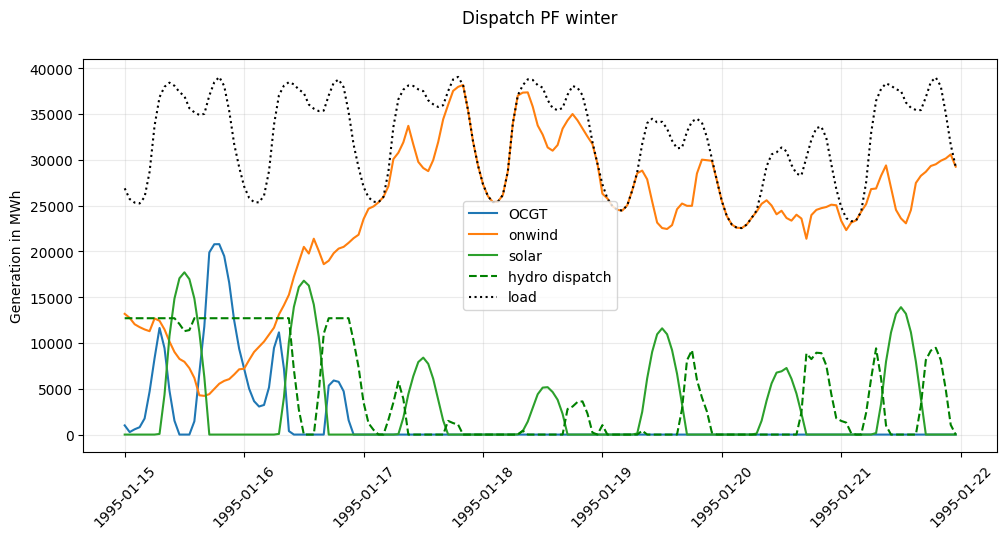

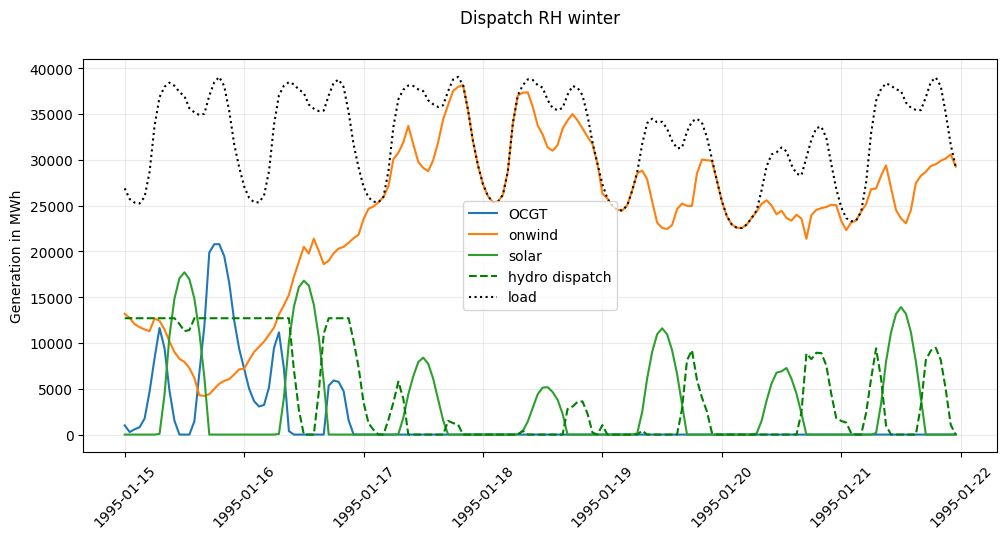

In [16]:
plot_dispatch(networks_pf[1995], start_hour=24*14, duration_hours=24*7, title="PF winter")
plot_dispatch(networks_rh[1995], start_hour=24*14, duration_hours=24*7, title="RH winter")

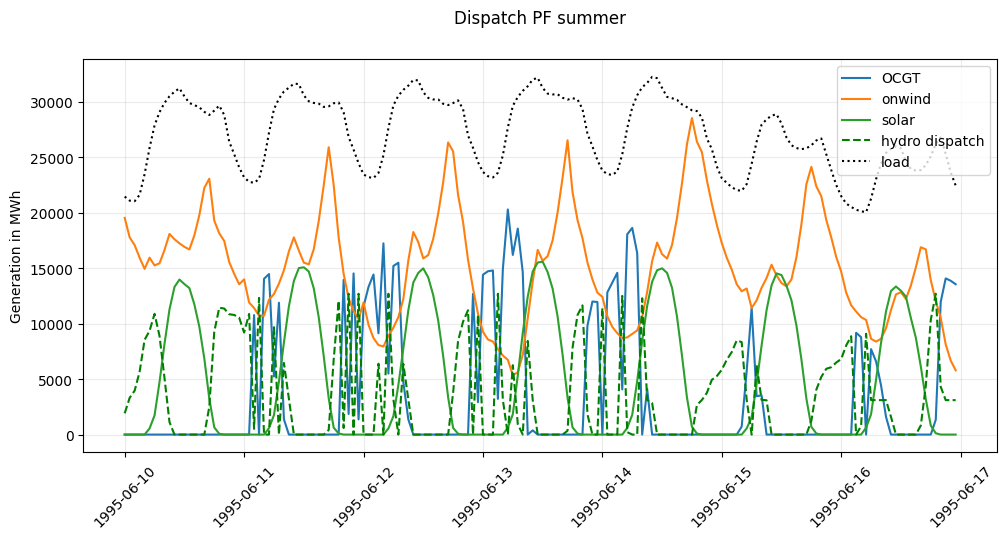

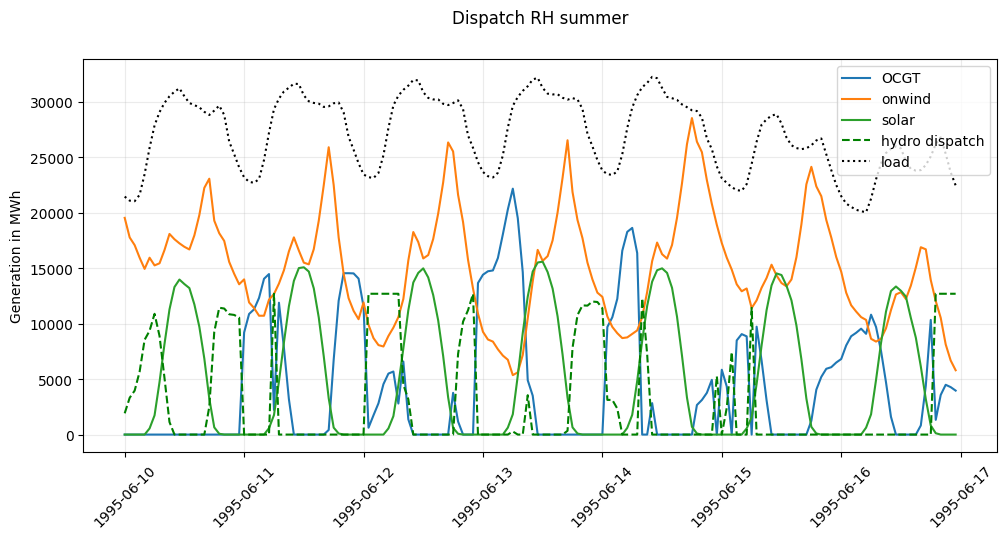

In [17]:
plot_dispatch(networks_pf[1995], start_hour=24*160, duration_hours=24*7, title="PF summer")
plot_dispatch(networks_rh[1995], start_hour=24*160, duration_hours=24*7, title="RH summer")

## Hydro dispatch and SOC plot

(<Figure size 1400x500 with 1 Axes>,
 <Axes: title={'center': 'Hydro - PF vs RH - ESP (1996 / 1996)'}, xlabel='Date', ylabel='MWh'>)

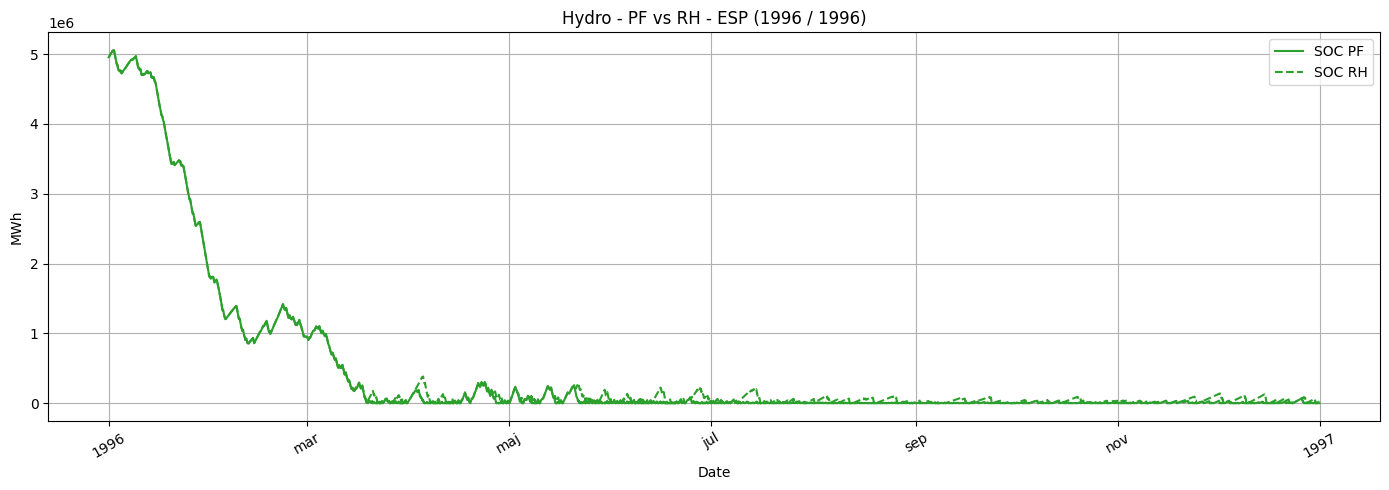

In [146]:
plot_hydro(network_rh = networks_rh[1996], network_pf = networks_pf[1996], same_axes=True, show_soc=True, show_dispatch=False, show_inflow = False, normalized = False ) 

### Weekly hydro levels

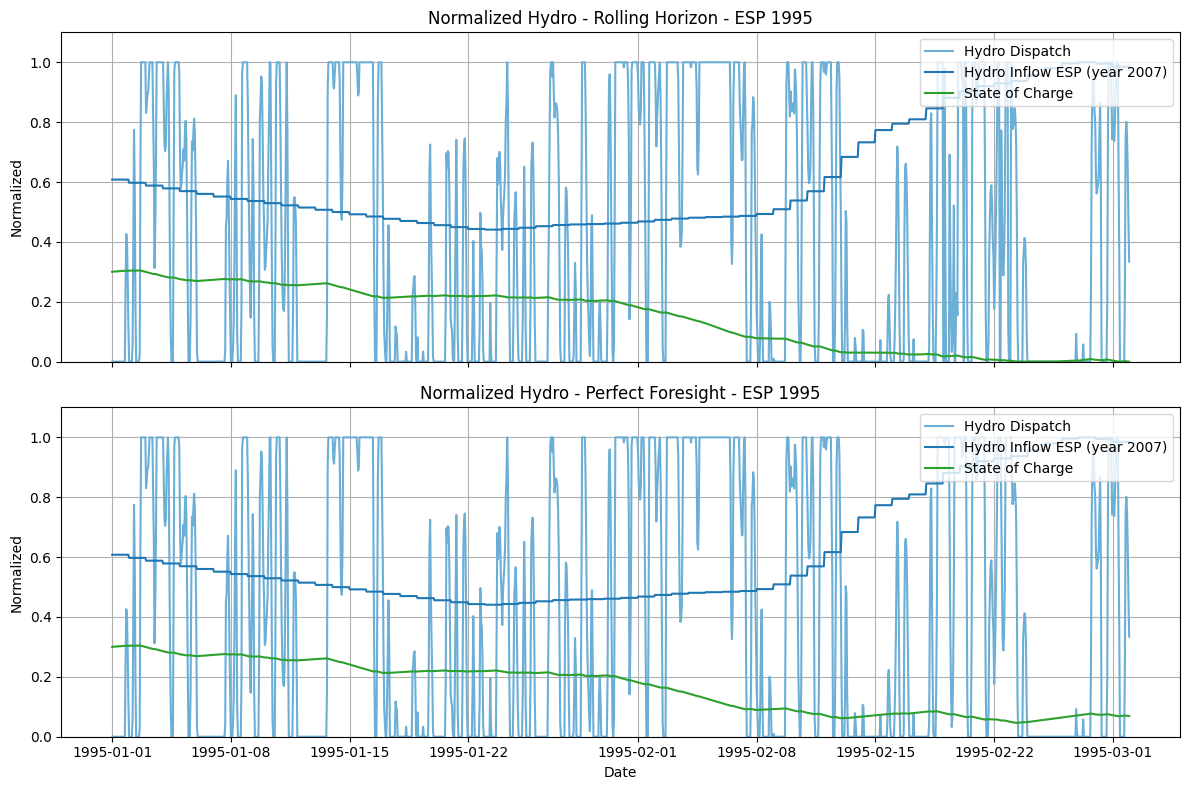

In [23]:
plot_normalized_hydro(networks_pf[1995], networks_rh[1995], interval=("1995-01-01", "1995-03-1"))


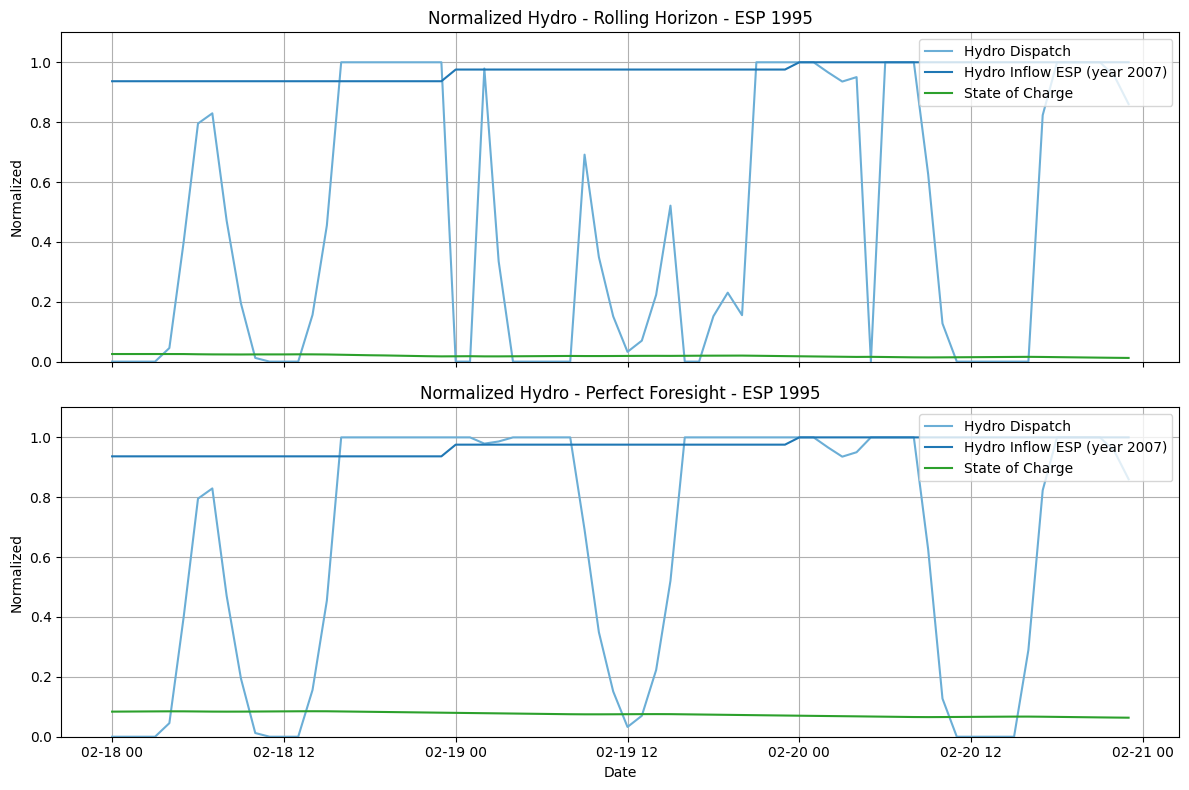

In [37]:
plot_normalized_hydro(networks_pf[1995], networks_rh[1995], interval=("1995-02-18", "1995-2-20"))


#### Plot same axis

(<Figure size 1400x500 with 1 Axes>,
 <Axes: title={'center': 'Normalized Hydro - PF vs RH - ESP (1995 / 1995)'}, ylabel='Normalized'>)

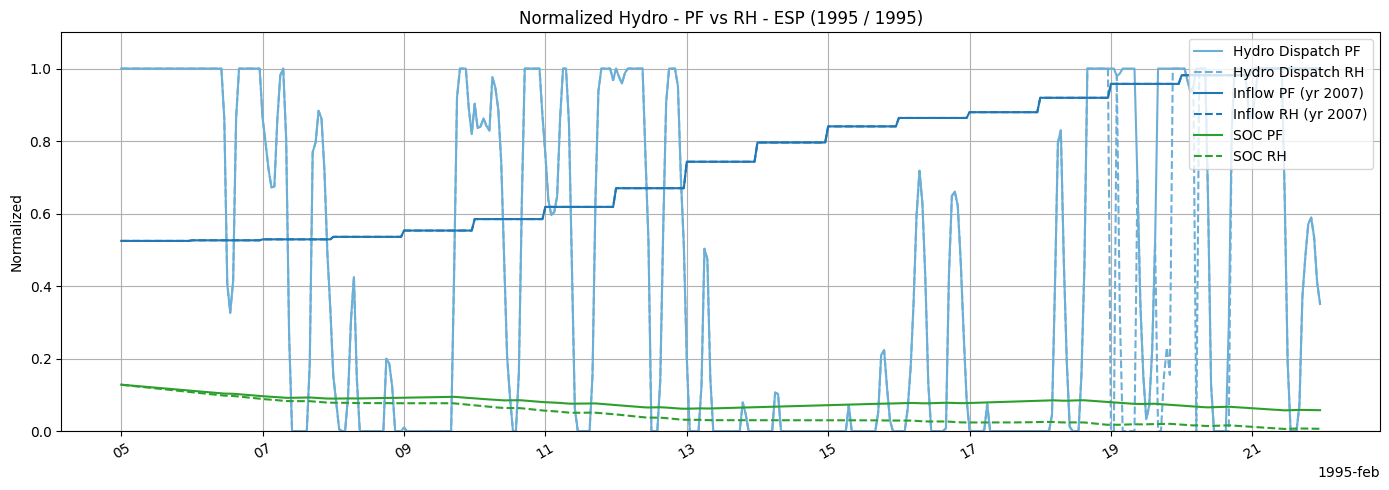

In [73]:
plot_hydro(networks_pf[1995], networks_rh[1995],
           interval=(mask),
           normalized=True, show_inflow=True, show_dispatch=True, show_soc=True,same_axes=True)

(<Figure size 1400x500 with 1 Axes>,
 <Axes: title={'center': 'Hydro - PF vs RH - ESP (1996 / 1996)'}, xlabel='Date', ylabel='MWh'>)

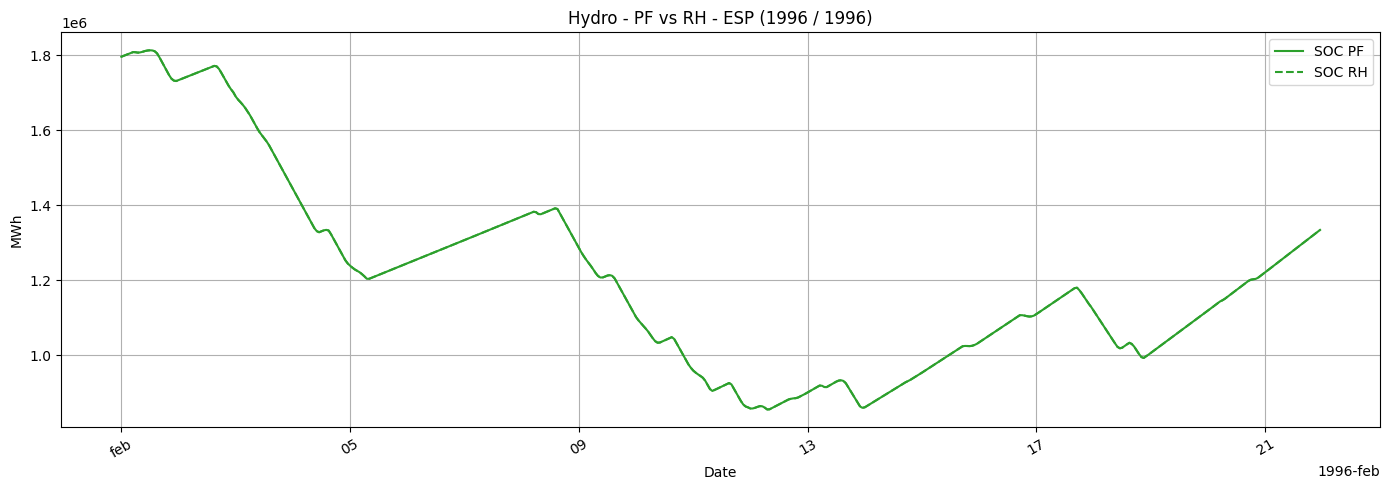

In [137]:
plot_hydro(networks_pf[1996], networks_rh[1996],
           interval=("1996-02-01", "1996-02-21"),
           normalized=False, show_inflow=False, show_dispatch=False, show_soc=True,same_axes=True)

In [66]:
net_rh.storage_units_t.inflow["Reservoir hydro storage"][mask[0]:mask[1]].sum()

np.float64(1474080.0)

In [83]:
net_rh.storage_units_t.spill.sum()

StorageUnit
Reservoir hydro storage    3.167578e+06
dtype: float64

In [84]:
net_pf.storage_units_t.spill.sum()

StorageUnit
Reservoir hydro storage    197215.370095
dtype: float64

In [86]:
net_rh.storage_units_t.spill["Reservoir hydro storage"][mask[0]:mask[1]]

snapshot
1995-02-05 00:00:00    2573.0
1995-02-05 01:00:00    2573.0
1995-02-05 02:00:00    2573.0
1995-02-05 03:00:00    2573.0
1995-02-05 04:00:00    2573.0
                        ...  
1995-02-21 19:00:00       0.0
1995-02-21 20:00:00       0.0
1995-02-21 21:00:00       0.0
1995-02-21 22:00:00       0.0
1995-02-21 23:00:00       0.0
Name: Reservoir hydro storage, Length: 408, dtype: float64

In [99]:
net_rh.storage_units_t.spill["Reservoir hydro storage"][mask[0]:mask[1]].sum()

np.float64(1037115.0)

In [92]:
# FIND DELTA SOC - ligner det SPILL? kan det forklare det? 
net_rh.storage_units_t.state_of_charge["Reservoir hydro storage"][mask[0]:mask[1]]
charge_rh = [net_rh.storage_units_t.state_of_charge["Reservoir hydro storage"][mask[0]:mask[1]]
[i - 1] - net_rh.storage_units_t.state_of_charge["Reservoir hydro storage"][mask[0]:mask[1]][i] for i in range(1, len(net_rh.storage_units_t.state_of_charge["Reservoir hydro storage"][mask[0]:mask[1]]))]
charge_pf = [net_pf.storage_units_t.state_of_charge["Reservoir hydro storage"][mask[0]:mask[1]]
[i - 1] - net_pf.storage_units_t.state_of_charge["Reservoir hydro storage"][mask[0]:mask[1]][i] for i in range(1, len(net_pf.storage_units_t.state_of_charge["Reservoir hydro storage"][mask[0]:mask[1]]))]

C:\Users\jonat\AppData\Local\Temp\ipykernel_1636\694279656.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  charge_rh = [net_rh.storage_units_t.state_of_charge["Reservoir hydro storage"][mask[0]:mask[1]]
C:\Users\jonat\AppData\Local\Temp\ipykernel_1636\694279656.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  [i - 1] - net_rh.storage_units_t.state_of_charge["Reservoir hydro storage"][mask[0]:mask[1]][i] for i in range(1, len(net_rh.storage_units_t.state_of_charge["Reservoir hydro storage"][mask[0]:mask[1]]))]
C:\Users\jonat\AppData\Local\Temp\ipykernel_1636\694279656.py:5: FutureWarning: Series.__getitem__ tre

In [95]:
df_charge = pd.DataFrame({'RH': charge_rh, 'PF': charge_pf})
df_charge

,RH,PF
0,14199.463327,11626.463327
1,14199.463327,11626.463327
2,14199.463327,11626.463327
3,14199.463327,11626.463327
4,14199.463327,11626.463327
...,...,...
402,3208.739093,3208.739093
403,3461.124867,3461.124867
404,2674.473200,2674.473200
405,932.663289,932.663289


In [98]:
diff_charge = df_charge['RH'] - df_charge['PF']
diff_charge

0      2.573000e+03
1      2.573000e+03
2      2.573000e+03
3      2.573000e+03
4      2.573000e+03
           ...     
402   -1.455192e-11
403    0.000000e+00
404   -5.820766e-11
405    1.455192e-11
406    2.910383e-11
Length: 407, dtype: float64

In [114]:
diff_charge.sum()

np.float64(844214.7800132486)

## Marginal prices

In [ ]:
N_test_class = Build_network_capacity_exp_gas(weather_year=2005, hydro_year=h_year_exp, demand_year=d_year_exp, data=All_data, cost_data=Cost, setup=setup_exp)
N_test = N_test_class.network

N_test.optimize(solver_name="gurobi", assign_all_duals=True)



Writing continuous variables.: 100%|██████████| 11/11 [00:00<00:00, 39.33it/s]


Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-20
Read LP format model from file C:\Users\jonat\AppData\Local\Temp\linopy-problem-7sr08ujb.lp
Reading time = 0.55 seconds
obj: 262809 rows, 131409 columns, 503882 nonzeros
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows 11.0 (26100.2))

CPU model: AMD Ryzen 7 5700U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 262809 rows, 131409 columns and 503882 nonzeros
Model fingerprint: 0xb1636ecb
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e-02, 2e+05]
  Bounds range     [6e+02, 6e+03]
  RHS range        [6e+02, 2e+07]
Presolve removed 153483 rows and 22424 columns
Presolve time: 0.34s
Presolved: 109326 rows, 108985 columns, 327975 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time

('ok', 'optimal')

In [ ]:
def plot_marginal_prices(network_pf, network_rh, month=None, interval=None):
    # Extract marginal prices (first bus column)
    mc_pf = network_pf.buses_t['marginal_price'].iloc[:, 0]
    mc_rh = network_rh.buses_t['marginal_price'].iloc[:, 0]

    # Apply month filter
    if month is not None:
        mc_pf = mc_pf[mc_pf.index.month == month]
        mc_rh = mc_rh[mc_rh.index.month == month]

    # Apply interval filter
    if interval is not None:
        start, end = interval
        mc_pf = mc_pf.loc[start:end]
        mc_rh = mc_rh.loc[start:end]

    # Plot
    plt.figure(figsize=(12, 5))
    plt.plot(mc_pf, label="Marginal prices PF", linestyle="--")
    plt.plot(mc_rh, label="Marginal prices RH", linestyle=":")
    plt.xlabel("Time")
    plt.ylabel("Marginal Price [EUR/MWh]")
    plt.title("Marginal Prices Comparison PF vs RH")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Cost calculations
    cost_pf = (network_pf.buses_t['marginal_price'].iloc[:, 0] * 
               network_pf.loads_t.p_set['load']).sum() / 1e6
    cost_rh = (network_rh.buses_t['marginal_price'].iloc[:, 0] * 
               network_rh.loads_t.p_set['load']).sum() / 1e6

    print(f"Sum of marginal prices (PF): {mc_pf.sum():.1f}")
    print(f"Sum of marginal prices (RH): {mc_rh.sum():.1f}")
    print(f"Total cost (PF) [MEUR]: {cost_pf:.2f}")
    print(f"Total cost (RH) [MEUR]: {cost_rh:.2f}")
    print(f"Total cost difference PF minus RH [MEUR]: {cost_pf - cost_rh:.2f}")


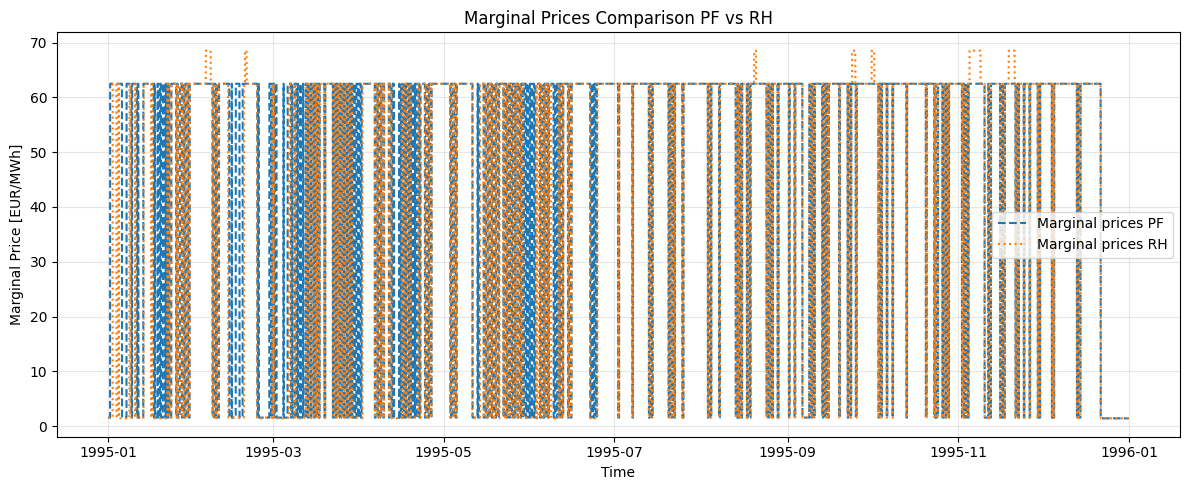

Sum of marginal prices (PF): 414463.9
Sum of marginal prices (RH): 377379.2
Total cost (PF) [MEUR]: 11842.88
Total cost (RH) [MEUR]: 10799.67
Total cost difference PF minus RH [MEUR]: 1043.21


In [ ]:
plot_marginal_prices(networks_pf[1995], networks_rh[1995])

### Specific periods

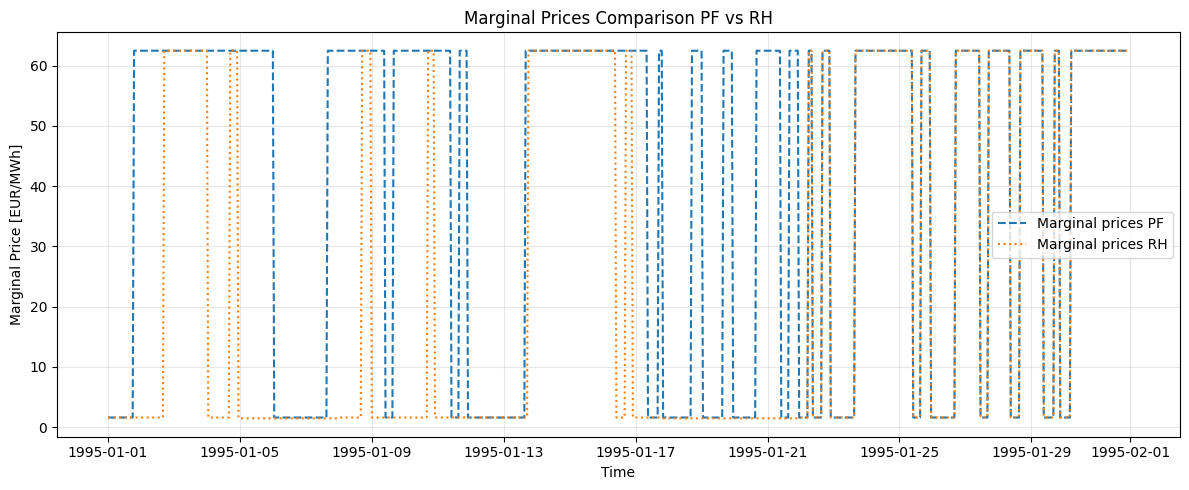

Sum of marginal prices (PF): 30407.1
Sum of marginal prices (RH): 17898.2
Total cost (PF) [MEUR]: 11842.88
Total cost (RH) [MEUR]: 10799.67
Total cost difference PF minus RH [MEUR]: 1043.21


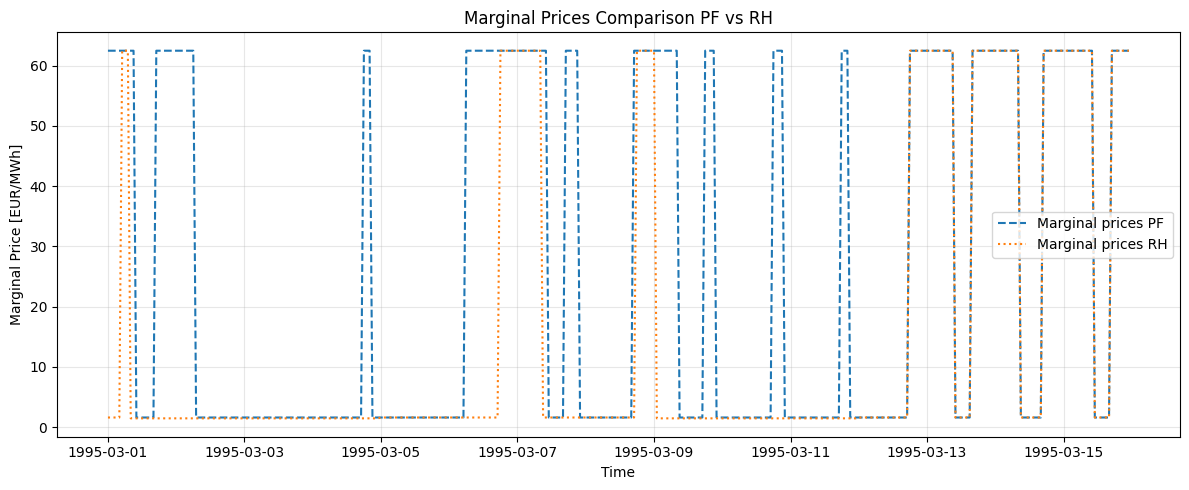

Sum of marginal prices (PF): 9459.9
Sum of marginal prices (RH): 5601.1
Total cost (PF) [MEUR]: 11842.88
Total cost (RH) [MEUR]: 10799.67
Total cost difference PF minus RH [MEUR]: 1043.21


In [ ]:
plot_marginal_prices(networks_pf[1995], networks_rh[1995], month=1)
plot_marginal_prices(networks_pf[1995], networks_rh[1995], interval=("1995-03-01", "1995-03-15"))


# Unique prices

In [149]:
# Assuming unique_prices is imported from functions.py and returns the unique marginal prices for a network
YEAR = 1993
pf_unique_prices = unique_prices(networks_pf[YEAR])
rh_unique_prices = unique_prices(networks_rh[YEAR])

print("Unique marginal prices (PF):", pf_unique_prices)
print("Unique marginal prices (RH):", rh_unique_prices)

Unique marginal prices (PF): [1.5, 65.4]
Unique marginal prices (RH): [1.5, 52.3, 65.4, 2000.0, 2000.0]
